# Improvise a Jazz Solo with an LSTM Network

Welcome to your final programming assignment of this week! In this notebook, you will implement a model that uses an LSTM to generate music. At the end, you'll even be able to listen to your own music! 

<img src="images/jazz.jpg" style="width:450;height:300px;">

**By the end of this assignment, you'll be able to:**

- Apply an LSTM to a music generation task
- Generate your own jazz music with deep learning
- Use the flexible Functional API to create complex models

This is going to be a fun one. Let's get started! 

## Table of Contents

- [Packages](#0)
- [1 - Problem Statement](#1)
    - [1.1 - Dataset](#1-1)
    - [1.2 - Model Overview](#1-2)
- [2 - Building the Model](#2)
    - [Exercise 1 - djmodel](#ex-1)
- [3 - Generating Music](#3)
    - [3.1 - Predicting & Sampling](#3-1)
        - [Exercise 2 - music_inference_model](#ex-2)
        - [Exercise 3 - predict_and_sample](#ex-3)
    - [3.2 - Generate Music](#3-2)
- [4 - References](#4)    

<a name='0'></a>
## Packages

Run the following cell to load all the packages you'll need. This may take a few minutes!

In [1]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from music21 import *
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *
from outputs import *
from test_utils import *

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

<a name='1'></a>
## 1 - Problem Statement

You would like to create a jazz music piece specially for a friend's birthday. However, you don't know how to play any instruments, or how to compose music. Fortunately, you know deep learning and will solve this problem using an LSTM network! 

You will train a network to generate novel jazz solos in a style representative of a body of performed work. 😎🎷

<a name='1-1'></a>
### 1.1 - Dataset

To get started, you'll train your algorithm on a corpus of Jazz music. Run the cell below to listen to a snippet of the audio from the training set:

In [2]:
IPython.display.Audio('./data/30s_seq.mp3')

The preprocessing of the musical data has been taken care of already, which for this notebook means it's been rendered in terms of musical "values." 

#### What are musical "values"? (optional)
You can informally think of each "value" as a note, which comprises a pitch and duration. For example, if you press down a specific piano key for 0.5 seconds, then you have just played a note. In music theory, a "value" is actually more complicated than this -- specifically, it also captures the information needed to play multiple notes at the same time. For example, when playing a music piece, you might press down two piano keys at the same time (playing multiple notes at the same time generates what's called a "chord"). But you don't need to worry about the details of music theory for this assignment. 

#### Music as a sequence of values

* For the purposes of this assignment, all you need to know is that you'll obtain a dataset of values, and will use an RNN model to generate sequences of values. 
* Your music generation system will use 90 unique values. 

Run the following code to load the raw music data and preprocess it into values. This might take a few minutes!

In [3]:
X, Y, n_values, indices_values, chords = load_music_utils('data/original_metheny.mid')
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 90
shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


You have just loaded the following:

- `X`: This is an (m, $T_x$, 90) dimensional array. 
    - You have m training examples, each of which is a snippet of $T_x =30$ musical values. 
    - At each time step, the input is one of 90 different possible values, represented as a one-hot vector. 
        - For example, X[i,t,:] is a one-hot vector representing the value of the i-th example at time t. 

- `Y`: a $(T_y, m, 90)$ dimensional array
    - This is essentially the same as `X`, but shifted one step to the left (to the past). 
    - Notice that the data in `Y` is **reordered** to be dimension $(T_y, m, 90)$, where $T_y = T_x$. This format makes it more convenient to feed into the LSTM later.
    - Similar to the dinosaur assignment, you're using the previous values to predict the next value.
        - So your sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be 90. 

- `indices_values`: python dictionary mapping integers 0 through 89 to musical values.

- `chords`: Chords used in the input midi

<a name='1-2'></a>
### 1.2 - Model Overview

Here is the architecture of the model you'll use. It's similar to the Dinosaurus model, except that you'll implement it in Keras.

<img src="images/music_generation.png" style="width:600;height:400px;">
<caption><center><font color='purple'><b>Figure 1</b>: Basic LSTM model </center></caption>


* $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \cdots, x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the musical corpus. 
* Each $x^{\langle t \rangle}$ is an index corresponding to a value.
* $\hat{y}^{\langle t \rangle}$ is the prediction for the next value.
* You'll be training the model on random snippets of 30 values taken from a much longer piece of music. 
    - Thus, you won't bother to set the first input $x^{\langle 1 \rangle} = \vec{0}$, since most of these snippets of audio start somewhere in the middle of a piece of music. 
    - You're setting each of the snippets to have the same length $T_x = 30$ to make vectorization easier.

## Overview of Section 2 and 3

In Section 2, you're going to train a model that predicts the next note in a style similar to the jazz music it's trained on. The training is contained in the weights and biases of the model. 

Then, in Section 3, you're going to use those weights and biases in a new model that predicts a series of notes, and using the previous note to predict the next note. 

* The weights and biases are transferred to the new model using the global shared layers (`LSTM_cell`, `densor`, `reshaper`) described below

<a name='2'></a>
## 2 - Building the Model

Now, you'll build and train a model that will learn musical patterns. 
* The model takes input X of shape $(m, T_x, 90)$ and labels Y of shape $(T_y, m, 90)$. 
* You'll use an LSTM with hidden states that have $n_{a} = 64$ dimensions.

In [4]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 64

#### Sequence generation uses a for-loop
* If you're building an RNN where, at test time, the entire input sequence $x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \ldots, x^{\langle T_x \rangle}$ is given in advance, then Keras has simple built-in functions to build the model. 
* However, for **sequence generation, at test time you won't know all the values of $x^{\langle t\rangle}$ in advance**.
* Instead, you'll generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$. 
    * The input at time "t" is the prediction at the previous time step "t-1".
* So you'll need to implement your own for-loop to iterate over the time steps. 

#### Shareable weights
* The function `djmodel()` will call the LSTM layer $T_x$ times using a for-loop.
* It is important that all $T_x$ copies have the same weights. 
    - The $T_x$ steps should have shared weights that aren't re-initialized.
* Referencing a globally defined shared layer will utilize the same layer-object instance at each time step.
* The key steps for implementing layers with shareable weights in Keras are: 
1. Define the layer objects (you'll use global variables for this).
2. Call these objects when propagating the input.

#### 3 types of layers
* The layer objects you need for global variables have been defined.  
    * Just run the next cell to create them! 
* Please read the Keras documentation and understand these layers: 
    - [Reshape()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape): Reshapes an output to a certain shape.
    - [LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Long Short-Term Memory layer
    - [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): A regular fully-connected neural network layer.

In [5]:
n_values = 90 # number of music values
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

* `reshaper`, `LSTM_cell` and `densor` are globally defined layer objects that you'll use to implement `djmodel()`. 
* In order to propagate a Keras tensor object X through one of these layers, use `layer_object()`.
    - For one input, use `layer_object(X)`
    - For more than one input, put the inputs in a list: `layer_object([X1,X2])`

<a name='ex-1'></a>
### Exercise 1 - djmodel

Implement `djmodel()`.

#### Inputs (given)

* The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
* The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
    - For example,
    ```Python
    X = Input(shape=(Tx, n_values)) # X has 3 dimensions and not 2: (m, Tx, n_values)
    ```
    
**Step 1: Outputs**

* Create an empty list "outputs" to save the outputs of the LSTM Cell at every time step.

#### Step 2: Loop through time steps (TODO)
* Loop for $t \in 1, \ldots, T_x$:

#### 2A. Select the 't' time-step vector from `X`.
* X has the shape (m, Tx, n_values).
* The shape of the 't' selection should be (n_values,). 
* Recall that if you were implementing in numpy instead of Keras, you would extract a slice from a 3D numpy array like this:
```Python
var1 = array1[:,1,:]
```
    
#### 2B. Reshape `x` to be (1, n_values).
* Use the `reshaper()` layer.  This is a function that takes the previous layer as its input argument.

#### 2C. Run `x` through one step of `LSTM_cell`.

* Initialize the `LSTM_cell` with the previous step's hidden state $a$ and cell state $c$. 
* Use the following formatting:
```python
next_hidden_state, _, next_cell_state = LSTM_cell(inputs=input_x, initial_state=[previous_hidden_state, previous_cell_state])
```
    * Choose appropriate variables for inputs, hidden state and cell state.

#### 2D. Dense layer
* Propagate the LSTM's hidden state through a dense+softmax layer using `densor`. 
    
#### 2E. Append output
* Append the output to the list of "outputs".

#### Step 3: After the loop, create the model
* Use the Keras `Model` object to create a model. There are two ways to instantiate the `Model` object. One is by subclassing, which you won't use here. Instead, you'll use the highly flexible Functional API, which you may remember from an earlier assignment in this course! With the Functional API, you'll start from your Input, then specify the model's forward pass with chained layer calls, and finally create the model from inputs and outputs.

* Specify the inputs and output like so:
```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```
    * Then, choose the appropriate variables for the input tensor, hidden state, cell state, and output.
* See the documentation for [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: djmodel

def djmodel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the djmodel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = densor.units
    
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values)) 
    
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop over tx
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = X[:,t,:]
        # Step 2.B: Use reshaper to reshape x to be (1, n_values) (≈1 line)
        x = reshaper(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

#### Create the model object
* Run the following cell to define your model. 
* We will use `Tx=30`. 
* This cell may take a few seconds to run. 

In [7]:
model = djmodel(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [8]:
# UNIT TEST
output = summary(model) 
comparator(output, djmodel_out)

All tests passed!


In [9]:
# Check your model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 90)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 90)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 90)        0           tf_op_layer_strided_slice[0][0]  
                                                                 tf_op_layer_strided_slice_1[0][0]
                                                                 tf_op_layer_strided_slice_2[0][0]
                                                                 tf_op_layer_strided_sl

**Expected Output**  
Scroll to the bottom of the output, and you'll see the following:

```Python
Total params: 45,530
Trainable params: 45,530
Non-trainable params: 0
```

#### Compile the model for training
* You now need to compile your model to be trained. 
* We will use:
    - optimizer: Adam optimizer
    - Loss function: categorical cross-entropy (for multi-class classification)

In [10]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Initialize hidden state and cell state
Finally, let's initialize `a0` and `c0` for the LSTM's initial state to be zero. 

In [11]:
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

#### Train the model

You're now ready to fit the model! 

* You'll turn `Y` into a list, since the cost function expects `Y` to be provided in this format. 
    - `list(Y)` is a list with 30 items, where each of the list items is of shape (60,90). 
    - Train for 100 epochs (This will take a few minutes). 

In [12]:
history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

loss at epoch 1: 129.74159240722656
loss at epoch 100: 9.095829010009766


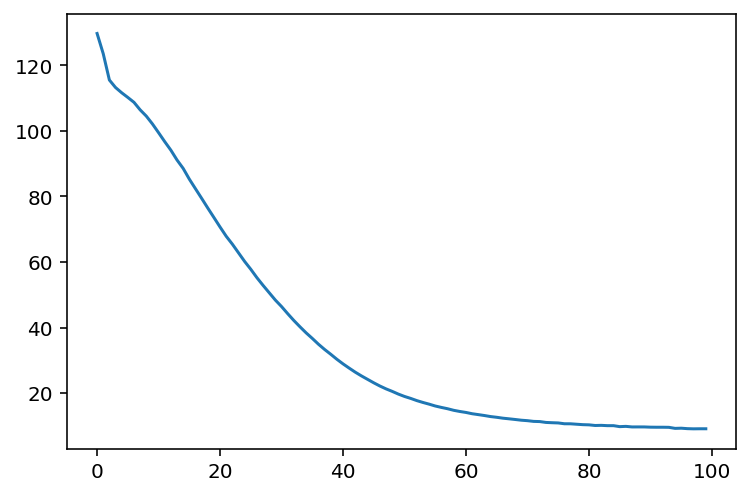

In [13]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])



#### Expected Output

The model loss will start high, (100 or so), and after 100 epochs, it should be in the single digits.  These won't be the exact number that you'll see, due to random initialization of weights.  
For example:
```
loss at epoch 1: 129.88641357421875
...
```
Scroll to the bottom to check Epoch 100
```
loss at epoch 100: 9.21483039855957
```

Now that you have trained a model, let's go to the final section to implement an inference algorithm, and generate some music! 

<a name='3'></a>
## 3 - Generating Music

You now have a trained model which has learned the patterns of a jazz soloist. You can now use this model to synthesize new music! 

<a name='3-1'></a>
### 3.1 - Predicting & Sampling

<img src="images/music_gen.png" style="width:600;height:400px;">
<center><caption><b><font color='purple'>Figure 2: Generating new values in an LSTM </b></font>

At each step of sampling, you will:
* Take as input the activation '`a`' and cell state '`c`' from the previous state of the LSTM.
* Forward propagate by one step.
* Get a new output activation, as well as cell state. 
* The new activation '`a`' can then be used to generate the output using the fully connected layer, `densor`. 

#### Initialization
* You'll initialize the following to be zeros:
    * `x0` 
    * hidden state `a0` 
    * cell state `c0` 

<a name='ex-2'></a>
### Exercise 2 - music_inference_model

Implement `music_inference_model()` to sample a sequence of musical values.

Here are some of the key steps you'll need to implement inside the for-loop that generates the $T_y$ output characters: 

**Step 1**: Create an empty list "outputs" to save the outputs of the LSTM Cell at every time step.

**Step 2.A**: Use `LSTM_Cell`, which takes in the input layer, as well as the previous step's '`c`' and '`a`' to generate the current step's '`c`' and '`a`'. 

```Python
next_hidden_state, _, next_cell_state = LSTM_cell(input_x, initial_state=[previous_hidden_state, previous_cell_state])
```
   - Choose the appropriate variables for `input_x`, `hidden_state`, and `cell_state`

**2.B**: Compute the output by applying `densor` to compute a softmax on '`a`' to get the output for the current step. 

**2.C**: Append the output to the list `outputs`.

**2.D**: Convert the last output into a new input for the next time step. You will do this in 2 substeps:
- Get the index of the maximum value of the predicted output using `tf.math.argmax` along the last axis.
- Convert the index into its n_values-one-hot encoding using `tf.one_hot`.

**2.E**: Use `RepeatVector(1)(x)` to convert the output of the one-hot enconding with shape=(None, 90) into a tensor with shape=(None, 1, 90)

#### Step 3: Inference Model:  
This is how to use the Keras `Model` object:

```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```

* Choose the appropriate variables for the input tensor, hidden state, cell state, and output.

**Hint**: the inputs to the model are the **initial** inputs and states.

In [14]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: music_inference_model

def music_inference_model(LSTM_cell, densor, Ty=100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, 90) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x, n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model

Run the cell below to define your inference model. This model is hard coded to generate 50 values.

In [15]:
inference_model = music_inference_model(LSTM_cell, densor, Ty = 50)

In [16]:
# UNIT TEST
inference_summary = summary(inference_model) 
comparator(inference_summary, music_inference_model_out)

All tests passed!


In [17]:
# Check the inference model
inference_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 90)]      0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  39680       input_2[0][0]                    
                                                                 a0[0][0]              

**Expected Output**

If you scroll to the bottom of the output, you'll see:
```
Total params: 45,530
Trainable params: 45,530
Non-trainable params: 0
```

#### Initialize inference model
The following code creates the zero-valued vectors you will use to initialize `x` and the LSTM state variables `a` and `c`. 

In [18]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

<a name='ex-3'></a>
### Exercise 3 - predict_and_sample

Implement `predict_and_sample()`. 

This function takes many arguments, including the inputs `x_initializer`, `a_initializer`, and `c_initializer`. 

In order to predict the output corresponding to this input, you'll need to carry out 3 steps:


#### Step 1:

* Use your inference model to predict an output given your set of inputs. The output `pred` should be a list of length $T_y$ where each element is a numpy-array of shape (1, n_values).
```Python
inference_model.predict([input_x_init, hidden_state_init, cell_state_init])
```
    * Choose the appropriate input arguments to `predict` from the input arguments of this `predict_and_sample` function.
 
#### Step 2:

* Convert `pred` into a numpy array of $T_y$ indices. 
    * Each index is computed by taking the `argmax` of an element of the `pred` list. 
    * Use [numpy.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html).
    * Set the `axis` parameter.
        * Remember that the shape of the prediction is $(m, T_{y}, n_{values})$

#### Step 3: 

* Convert the indices into their one-hot vector representations. 
    * Use [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).
    * Set the `num_classes` parameter. Note that for grading purposes: you'll need to either:
        * Use a dimension from the given parameters of `predict_and_sample()` (for example, one of the dimensions of x_initializer has the value for the number of distinct classes).
        * Or just hard code the number of distinct classes (will pass the grader as well).
        * **Note** that using a global variable such as `n_values` will not work for grading purposes.

In [27]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: predict_and_sample

def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 90), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=90)
    ### END CODE HERE ###
    
    return results, indices

In [28]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

np.argmax(results[12]) = 77
np.argmax(results[17]) = 60
list(indices[12:18]) = [array([77]), array([24]), array([74]), array([15]), array([54]), array([60])]


**Expected (Approximate) Output**: 

* Your results **may likely differ** because Keras' results are not completely predictable. 
* However, if you have trained your LSTM_cell with model.fit() for exactly 100 epochs as described above: 
    * You should very likely observe a sequence of indices that are not all identical.  Perhaps with the following values:
<table>
    <tr>
        <td>
            **np.argmax(results[12])** =
        </td>
        <td>
        26
        </td>
    </tr>
    <tr>
        <td>
            **np.argmax(results[17])** =
        </td>
        <td>
        7
        </td>
    </tr>
    <tr>
        <td>
            **list(indices[12:18])** =
        </td>
        <td>
            [array([26]), array([18]), array([53]), array([27]), array([40]), array([7])]
        </td>
    </tr>
</table>

<a name='3-2'></a>
### 3.2 - Generate Music 

Finally! You're ready to generate music. 

Your RNN generates a sequence of values. The following code generates music by first calling your `predict_and_sample()` function. These values are then post-processed into musical chords (meaning that multiple values or notes can be played at the same time). 

Most computational music algorithms use some post-processing because it's difficult to generate music that sounds good without it. The post-processing does things like clean up the generated audio by making sure the same sound is not repeated too many times, or that two successive notes are not too far from each other in pitch, and so on. 

One could argue that a lot of these post-processing steps are hacks; also, a lot of the music generation literature has also focused on hand-crafting post-processors, and a lot of the output quality depends on the quality of the post-processing and not just the quality of the model. But this post-processing does make a huge difference, so you should use it in your implementation as well. 

Let's make some music! 

Run the following cell to generate music and record it into your `out_stream`. This can take a couple of minutes.

In [29]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
Generated 32 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 32 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 32 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 32 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 32 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


Using a basic midi to wav parser you can have a rough idea about the audio clip generated by this model. The parser is very limited.

In [30]:
mid2wav('output/my_music.midi')
IPython.display.Audio('./output/rendered.wav')

To listen to your music, click File->Open... Then go to "output/" and download "my_music.midi". Either play it on your computer with an application that can read midi files if you have one, or use one of the free online "MIDI to mp3" conversion tools to convert this to mp3.  

As a reference, here is a 30 second audio clip generated using this algorithm:

In [31]:
IPython.display.Audio('./data/30s_trained_model.mp3')

## Congratulations!

You've completed this assignment, and generated your own jazz solo! The Coltranes would be proud. 

By now, you've: 

- Applied an LSTM to a music generation task
- Generated your own jazz music with deep learning
- Used the flexible Functional API to create a more complex model

This was a lengthy task. You should be proud of your hard work, and hopefully you have some good music to show for it. Cheers and see you next time! 

<font color='blue'><b> What you should remember:</b>
    
- A sequence model can be used to generate musical values, which are then post-processed into midi music. 
- You can use a fairly similar model for tasks ranging from generating dinosaur names to generating original music, with the only major difference being the input fed to the model.  
- In Keras, sequence generation involves defining layers with shared weights, which are then repeated for the different time steps $1, \ldots, T_x$. 

<a name='4'></a>
## 4 - References

The ideas presented in this notebook came primarily from three computational music papers cited below. The implementation here also took significant inspiration and used many components from Ji-Sung Kim's GitHub repository.

- Ji-Sung Kim, 2016, [deepjazz](https://github.com/jisungk/deepjazz)
- Jon Gillick, Kevin Tang and Robert Keller, 2009. [Learning Jazz Grammars](http://ai.stanford.edu/~kdtang/papers/smc09-jazzgrammar.pdf)
- Robert Keller and David Morrison, 2007, [A Grammatical Approach to Automatic Improvisation](http://smc07.uoa.gr/SMC07%20Proceedings/SMC07%20Paper%2055.pdf)
- François Pachet, 1999, [Surprising Harmonies](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.5.7473&rep=rep1&type=pdf)

Finally, a shoutout to François Germain for valuable feedback.